This program generates the spin wave frequencies versus inverse film thickness, shown in Figure 5 of the article.<br>
<br>
Results of the atomic layer method, as well as the corresponding continuum method, are displayed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig
from matplotlib.ticker import MaxNLocator
from scipy.optimize import curve_fit
import sympy as sp
from sympy import expand, symbols 

In [2]:
# Define Kostylev's 2Nx2N-4 matrix with boundary condition intergrated in to layer 2 and N-1:----------------------------
def MatrixKdem(L,N,D,k):
    SW = np.zeros((2*N-4,2*N-4), dtype=np.complex128)              # setup 2Nx2N-4 Matrix
    nn=np.linspace(0,N-1-2,N-2)                                    # counter for iteration
    dy=L/N                                                         # steps side \Delta
    dD=(-D)*k*b/A                                                  # d_D short hand (contain DMI const.)
    B_zee = mu_0*H                                                 # Zeeman effective field term
    B_ex = 2*A/(M_0*(dy**2))                                       # exchange effecive field term
    B_DM = dD*dy*B_ex/(1-(dD**2)*(dy**2))                          # DMI effective field term
    B_dem=mu_0*M_0
    for nn in range(0,1):                                          # i=2:
        SW[0][0]=-(1j)*B_DM                                        # x-direction x_2
        SW[0][1]=(B_zee+((dy**2)*(k**2)+2)*B_ex-B_DM/(dy*dD)+B_dem)      # x-direction y_2
        SW[0][3]=-B_ex                                             # x-direction y_3
        SW[1][0]=-(B_zee+((dy**2)*(k**2)+2)*B_ex-B_DM/(dy*dD))     # y-direction x_2
        SW[1][1]=-(1j)*B_DM                                        # y-direction y_2
        SW[1][2]=B_ex                                              # y-direction x_3
        for nn in range(1,N-1-2):                                  # any i layers:
            SW[2*nn][2*(nn-1)+1]=-B_ex                             # x-direction y_i-1
            SW[2*nn][2*nn+1]=(B_zee+((dy**2)*(k**2)+2)*B_ex+B_dem)       # x-direction y_i
            SW[2*nn][2*(nn+1)+1]=-B_ex                             # x-direction y_i+1
            SW[2*nn+1][2*(nn-1)]=B_ex                              # y-direction x_i-1
            SW[2*nn+1][2*nn]=-(B_zee+((dy**2)*(k**2)+2)*B_ex)      # y-direction x_i
            SW[2*nn+1][2*(nn+1)]=B_ex                              # y-direction x_i+1
            for nn in range(N-1-2, N-2):                           # i=N-1:
                SW[2*nn][2*(nn-1)+1]=-B_ex                         # x-direction y_N-2
                SW[2*nn][2*nn+1]=(B_zee+((dy**2)*(k**2)+1)*B_ex+B_dem)   # X-direction y_N-1
                SW[2*nn+1][2*(nn-1)]=B_ex                          # y-direction x_N-2
                SW[2*nn+1][2*nn]=-(B_zee+((dy**2)*(k**2)+1)*B_ex)  # y-direction x_N-1
    return SW*gamma/(1j)
# 2Nx2N Matrix with demag. switch off------------------------------------------------------------------------------------
def Matr_0dem(N,D,kx,kz):                                         # N layernumber D DMI cost. k_x, k_z wavenumbers
    SW = np.zeros((2*N,2*N), dtype=np.complex128)              # set up 2N x 2N matrix
    nn=np.linspace(0,N-1,N)                                    # counter for iteration
    K_ex = 2*(np.cos(a*kx)+np.cos(a*kz))                       # exchange term of the wavenumber
    K_DM = np.sin(a*kx)                                        # DMI term of the wavenumber
    B_DM = 2*D/(a*M_0)                                         # DMI effective field term
    B_ex = 2*A/( (a**2)*M_0 )                                  # exchange effective field term
    B_de = 0                                                   # demagnetizing effective field term switch off
    for nn in range(0,1):                                      # i=1 (top)
        SW[0][0]=1j*B_DM*K_DM                                  # x-direction x_1
        SW[0][1]=B+B_ex*(5-K_ex)+B_de                          # x-direction y_1
        SW[0][3]=-B_ex                                         # x-direction y_2
        SW[1][0]=-(B+B_ex*(5-K_ex))                            # y-direction x_1
        SW[1][1]=1j*B_DM*K_DM                                  # y-direction y_1
        SW[1][2]=B_ex                                          # y-direction x_2
        for nn in range(1,N-1):                                # any i layers inbetween
            SW[2*nn][2*(nn-1)+1]=-B_ex                         # x-direction y_i-1
            SW[2*nn][2*nn+1]=B+B_ex*(6-K_ex)+B_de              # x-direction y_i
            SW[2*nn][2*(nn+1)+1]=-B_ex                         # x-direction y_i+1
            SW[2*nn+1][2*(nn-1)]=B_ex                          # y-direction x_i-1
            SW[2*nn+1][2*nn]=-(B+B_ex*(6-K_ex))                # y-direction x_i
            SW[2*nn+1][2*(nn+1)]=B_ex                          # y-direction x_i+1
            for nn in range(N-1, N):                           # i=N (bottom)
                SW[2*nn][2*(nn-1)+1]=-B_ex                     # x-direction y_N-1
                SW[2*nn][2*nn+1]=B+B_ex*(5-K_ex)+B_de          # x-direction y_N
                SW[2*nn+1][2*(nn-1)]=B_ex                      # y-direction x_N-1
                SW[2*nn+1][2*nn]=-(B+B_ex*(5-K_ex))            # y-direction x_N
    return SW*gamma/(1j)                                       # move iw/|r| to the other side
# define frequency funciont for Kostylev's matrix ------------------------------------------------------------------------
def FreqK(N,SW,n):                                          # N #ofDiscretePoints SW Matrix'MatrixK(L,N,D,k)' n modenumber
    omegaGHz=[]                                             # set up empty list
    w,v=eig(SW)                                             # obtain eigan value and eigenvalues and eigenvectors
    omegaRaw=w                                              # extract raw arrays of eigenvalues
    idx1 = np.argsort(omegaRaw)                             # sort the eigenvalues in assending order
    omegaRaw = omegaRaw[idx1]                               # get the sortted index
    v = v[:,idx1]                                           # use the same index to sort the eigenvectors
    omega=np.zeros(N-2, dtype = 'complex_')                 # set up empty array for frequencies 
    for ii in range (0,N-2):                                # for loop to exact the right array
        omega[ii]=omegaRaw[ii+N-2]
    omegaGHz.append(omega.real[n]/1e9)                      # convert to GHz
    return omegaGHz
# define the mode amplitude function--------------------------------------------------------------------------------------
def ModAmpXK(N,SW,n):                                          # N discrete#points
    w,v=eig(SW)                                                # obtain eigenvalues and vectors
    omegaRaw=w                                                 # extract raw arrays of eigenvalues
    idx1 = np.argsort(omegaRaw)                                # sort the eigenvalues in assending order
    omegaRaw = omegaRaw[idx1]                                  # get the sortted index
    v = v[:,idx1]                                              # sort the eigenvectors by the new index
    EigV=np.zeros((2*(N-2),N-2),dtype = 'complex_')            # set up eigenvector arrays
    for ii in range (0,N-2):                                   # extract the amplitude on the X-direction
        for jj in range (0,2*(N-2)):
            EigV[jj][ii]=v[jj][ii+N-2]
    EigVx=np.zeros((N-2,N-2),dtype=np.complex128)
    for ii in range (0,N-2):
        for jj in range (0,N-2):
            EigVx[ii][jj]=EigV[2*ii][jj]
            if abs(EigVx[ii][jj].real)>abs(EigVx[ii][jj].imag):
                EigVx[ii][jj]=EigVx[ii][jj].real
            else:
                EigVx[ii][jj]=EigVx[ii][jj].imag
    return EigVx[:,n].real
# set up array for the layer number --------------------------------------------------------------------------------------
    layers=np.linspace(2,N-1,N-2)
    return layers
# define dispersion relation iteration -----------------------------------------------------------------------------------
def SWfreqkxK(L,N,D,h,n):                                   # L layer thickness N layer# D DMI const. h stepsize n mode#
    Max=30.1e6                                                   # maximum wavenumber
    omega1=[]                                               # set up frequency list
    kx=-Max                                                 # starting k_x  
    while kx<Max+1e6:                                       # while loop appends all the freqencies within wavenumber range
        omega1.append(FreqK(N,MatrixK(L,N,D,kx),n))
        kx=kx+h*1e6                                         # increase steps
    return omega1
def SWfreqkx0(N,D,h,n):                                     # N layernumber D DMI const. h stepsize n modenumber
    Max=30.1e6                                              # maximum wavenumber
    omega1=[]                                               # set up frequency list
    kx=-Max                                                 # starting k_x
    kz=0                                                    # set k_z = 0
    while kx<Max+1e6:                                       # while loop appends all the freqencies within wavenumber range
        omega1.append(Freq(N,Matr_0dem(N,D,kx,kz),n))
        kx=kx+h*1e6                                         # increase steps
    return omega1
def xSWfreqkxK(h):                                          # h stepsize 
    Max=30.1e6
    x=[]
    kx=-Max
    kz=0
    while kx<Max+1e6:
        x.append(kx/1e6)
        kx=kx+h*1e6
    return x

In [3]:
# define 2Nx2N Matrix function---------------------------------------------------------------
def Matrix(N,D,kx,kz):                                         # N layernumber D DMI cost. k_x, k_z wavenumbers
    SW = np.zeros((2*N,2*N), dtype=np.complex128)              # set up 2N x 2N matrix
    nn=np.linspace(0,N-1,N)                                    # counter for iteration
    K_ex = 2*(np.cos(a*kx)+np.cos(a*kz))                       # exchange term of the wavenumber
    K_DM = np.sin(a*kx)                                        # DMI term of the wavenumber
    B_DM = 2*D/(a*M_0)                                         # DMI effective field term
    B_ex = 2*A/( (a**2)*M_0 )                                  # exchange effective field term
    B_de = mu_0*M_0                                            # demagnetizing effective field term
    for nn in range(0,1):                                      # i=1 (top)
        SW[0][0]=1j*B_DM*K_DM                                  # x-direction x_1
        SW[0][1]=B+B_ex*(5-K_ex)+B_de                          # x-direction y_1
        SW[0][3]=-B_ex                                         # x-direction y_2
        SW[1][0]=-(B+B_ex*(5-K_ex))                            # y-direction x_1
        SW[1][1]=1j*B_DM*K_DM                                  # y-direction y_1
        SW[1][2]=B_ex                                          # y-direction x_2
        for nn in range(1,N-1):                                # any i layers inbetween
            SW[2*nn][2*(nn-1)+1]=-B_ex                         # x-direction y_i-1
            SW[2*nn][2*nn+1]=B+B_ex*(6-K_ex)+B_de              # x-direction y_i
            SW[2*nn][2*(nn+1)+1]=-B_ex                         # x-direction y_i+1
            SW[2*nn+1][2*(nn-1)]=B_ex                          # y-direction x_i-1
            SW[2*nn+1][2*nn]=-(B+B_ex*(6-K_ex))                # y-direction x_i
            SW[2*nn+1][2*(nn+1)]=B_ex                          # y-direction x_i+1
            for nn in range(N-1, N):                           # i=N (bottom)
                SW[2*nn][2*(nn-1)+1]=-B_ex                     # x-direction y_N-1
                SW[2*nn][2*nn+1]=B+B_ex*(5-K_ex)+B_de          # x-direction y_N
                SW[2*nn+1][2*(nn-1)]=B_ex                      # y-direction x_N-1
                SW[2*nn+1][2*nn]=-(B+B_ex*(5-K_ex))            # y-direction x_N
    return SW*gamma/(1j)                                       # move iw/|r| to the other side
# define frequncy function------------------------------------------------------------------
def Freq(N,SW,n):                                              # N layernumber SW matrix:'Matrix(N,D,kx,kz)' n modenumber 
    omegaGHz=[]                                                # set up list for the frequencies with unit GHz
    w,v=eig(SW)                                                # obtain eigenvalues and vectors
    omegaRaw = w                                               # extract raw freqencies arrays
    idx1 = np.argsort(omegaRaw)                                # sort the freqencies
    omegaRaw = omegaRaw[idx1]                                  # extract the sorted freqencies index        
    omega=np.zeros(N, dtype = 'complex_')                      # set up freqency array with unit Hz
    for ii in range (0,N):                                     # extract the correct freqencies arrays
        omega[ii]=omegaRaw[ii+N]
    omegaGHz.append(omega.real[n]/1e9)                         # convert to GHz
    return omegaGHz
# define dispersion relation freq. and wavenumber for long wavelength-----------------------
# increasing only in kx, define freqency list function
def SWfreqkx(N,D,h,n):                                         # N layernumber D DMI const. h stepsize n modenumber
    Max=30e6                                                   # maximum wavenumber
    omega1=[]                                                  # set up frequency list
    kx=-Max                                                    # starting k_x
    kz=0                                                       # set k_z = 0
    while kx<Max+1e6:                                          
        omega1.append(Freq(N,Matrix(N,D,kx,kz),n))
        kx=kx+h*1e6                                            # increase steps
    return omega1
# define wavenumber list function
def xSWfreqkx(h):                                              # h stepsize 
    Max=30e6
    x=[]
    kx=-Max
    kz=0
    while kx<Max+1e6:
        x.append(kx/1e6)
        kx=kx+h*1e6
    return x
# increasing in both kx and kz, define freqency list function
def SWfreqkxkz(N,D,h,n):
    Max=30e6
    omega1=[]
    kx=-Max
    kz=-Max
    while kx<Max+1e6:                                         # 2 while loops allow kx and kz increases at the same time
        while kz<Max+1e6:
            omega1.append(Freq(N,Matrix(N,D,kx,kz),n))
            kx=kx+h*1e6
            kz=kz+h*1e6
    return omega1
# Mode amplitudes in x-direction (y-direction is the same) ---------------------------------------
def ModAmpX(N,SW,n):                                              # N layer number
    w,v=eig(SW)                                                   # obtain eigenvalue and vectors
    omegaRaw=w                                                    # exact the raw eigenvalue array 
    idx1 = np.argsort(omegaRaw)                                   # sort raw eigenvalue arrays
    omegaRaw = omegaRaw[idx1]                                     # obtain the sorted array by use new index
    v = v[:,idx1]                                                 # sort the eigen vector aby use new index
    EigV=np.zeros((2*N,N),dtype = 'complex_')
    for ii in range (0,N):                                        # obtain the amplitude in x-direction
        for jj in range (0,2*N):                                  
            EigV[jj][ii]=v[jj][ii+N]
    EigVx=np.zeros((N,N),dtype=np.complex128)
    for ii in range (0,N):
        for jj in range (0,N):
            EigVx[ii][jj]=EigV[2*ii][jj]
            if abs(EigVx[ii][jj].real)>abs(EigVx[ii][jj].imag):  
                EigVx[ii][jj]=EigVx[ii][jj].real
            else:
                EigVx[ii][jj]=EigVx[ii][jj].imag
    return EigVx[:,n].real
# layer number function --------------------------------------------------------
def xMobAmp(N):
    layers=np.linspace(1,N,N)
    return layers

def xMobthickness(N):
    layers=np.linspace(1,N,N)
    thickness=a*layers*1e9
    return thickness

In [4]:
# parameters of certain Permalloy form Kostylev's paper--------------------------------------
mu_0=4*np.pi*1e-7                    # permeability of free space
H=300*(1e3/(4*np.pi))                # external H field
A=1.355e-11                          # exchange constant 1.355e-11 J/m
M_0=1.05/mu_0                        # magnetization in z direction M_s A/M
gamma=(2*np.pi)*2.8e6/((1e3/(4*np.pi))*mu_0)   # gyromagnetic ratio 2.8 MHz/Oe
b=0.248e-9                          # atomic layer thickness
a=0.248e-9                          # lattice constant
B=H*mu_0     

In [5]:
#Matrix(N,D,kx,kz)
#Freq(N,SW,n)
def dw_nr(D,n,Nmax):
    kx1=20e6
    kx2=-20e6
    kz=0
    N=3
    dw_nr=[]
    while N<Nmax:
        sw1=Matrix(N,D,kx1,kz)
        sw2=Matrix(N,D,kx2,kz)
        dw_nr.append( (np.array(Freq(N,sw1,n))-np.array(Freq(N,sw2,n)))/(2*np.pi) )
        N=N+1
    return dw_nr

def xdw_nr(n,Nmax):
    N=3
    inv_n0=[]
    while N<Nmax:
        inv_n0.append( 1/(N*a*1e9) )
        N=N+1
    return inv_n0

In [6]:
def dw_nr2(D,n,Nmax):
    kx1=20e6
    kx2=-20e6
    N=3
    dw_nr2=[]
    while N<Nmax:
        L=N*b
        NN=N*10
        sw1=MatrixKdem(L,NN,D,kx1)
        sw2=MatrixKdem(L,NN,D,kx2)
        dw_nr2.append( (np.array(FreqK(NN,sw1,n))-np.array(FreqK(NN,sw2,n)))/(2*np.pi) )
        N=N+1
    return dw_nr2

def xdw_nr2(n,Nmax):
    N=3
    inv_n02=[]
    while N<Nmax:
        inv_n02.append( 1/(N*a*1e9) )
        N=N+1
    return inv_n02

In [7]:


xaxis=xdw_nr(0,101)
#n=0
ALMn0=dw_nr(4.2e-3,0,101)
Kostylevn0=dw_nr2(4.2e-3,0,101)
#n=1
ALMn1=dw_nr(4.2e-3,1,101)
Kostylevn1=dw_nr2(4.2e-3,1,101)
#n=2
ALMn2=dw_nr(4.2e-3,2,101)
Kostylevn2=dw_nr2(4.2e-3,2,101)


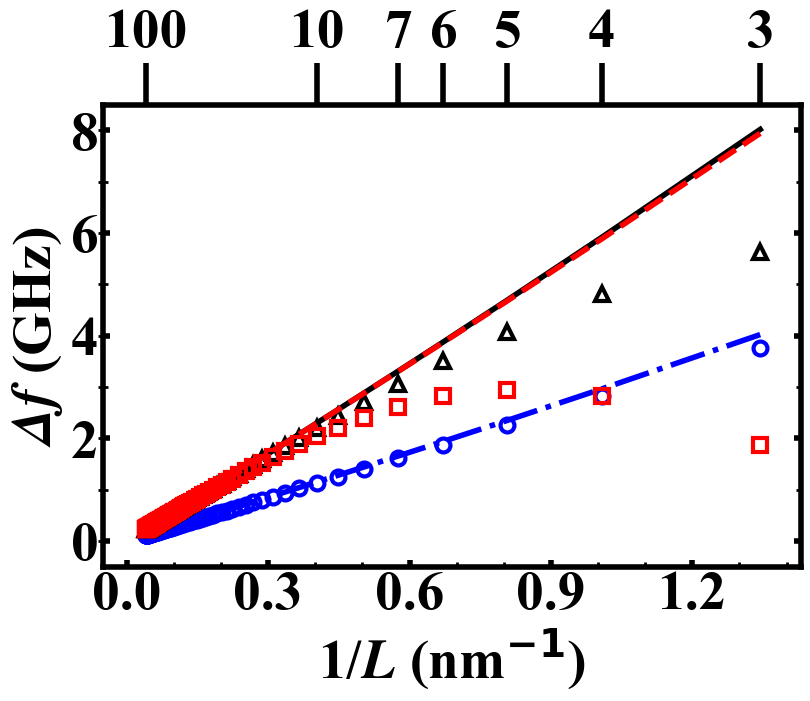

In [9]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'STIXGeneral:italic'
plt.rcParams['mathtext.bf'] = 'STIXGeneral:italic:bold'
fig, (ax) = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(xaxis,ALMn0,'o',color='blue',markerfacecolor='none',ms=10,markeredgewidth=3,label='Uniform',linewidth=2)
ax.plot(xaxis,Kostylevn0,'-.',color='blue',label='Kostylev',linewidth=4)
ax.plot(xaxis,ALMn1,'^',color='black',markerfacecolor='none',ms=10,markeredgewidth=3,label='1ex',linewidth=2)
ax.plot(xaxis,Kostylevn1,'-',color='black',label='Kostylev',linewidth=4)
ax.plot(xaxis,ALMn2,'s',color='red',markerfacecolor='none',ms=10,markeredgewidth=3,label='2nd',linewidth=2)
ax.plot(xaxis,Kostylevn2,'--',color='red',label='Kostylev',linewidth=4)
ax.set_xlabel(r'1/$\mathbf{L}$ (nm$^{-1}$)',weight='bold',fontsize=40)
ax.set_ylabel(r'$\mathbf{\Delta f}$ (GHz)',weight='bold',fontsize=40)
ax.tick_params(axis='x',direction='in', labelsize=40)
ax.tick_params(axis='y',direction='in',labelsize=40)
ax.set_ylim([-0.5,8.5])
ax.set_xlim([-0.05,1.43])

ax.set_xticks([0,0.3,0.6,0.9,1.2])
ax.tick_params(axis='x',direction='in',width=4,length=5,labelsize=40)
sec3 = ax.secondary_xaxis(location='bottom')
sec3.set_xticks(np.linspace(0,1.4,15),labels=None)
sec3.tick_params(axis='x',direction='in',width=2,labelbottom=False)
thd3 = ax.secondary_xaxis(location='top')
thd3.set_xticks([1/(100*a*1e9),1/(10*a*1e9),1/(7*a*1e9),1/(6*a*1e9),1/(5*a*1e9),1/(4*a*1e9),1/(3*a*1e9)]
                ,labels=[100,10,7,6,5,4,3])
thd3.tick_params(axis='x',direction='out',width=4,length=30,labelsize=40)

ax.set_yticks([0,2,4,6,8])
ax.tick_params(axis='y', right=True,direction='in',length=5,width=4,labelsize=40)
sec2 = ax.secondary_yaxis(location=0)
sec2.set_yticks(np.linspace(0,8,9),labels=None)
sec2.tick_params(axis='y',right=True,direction='in',width=2,labelleft=False)
thd2 = ax.secondary_yaxis(location='right')
thd2.set_yticks(np.linspace(0,8,9),labels=None)
thd2.tick_params(axis='y',direction='in',width=2,labelright=False)

plt.setp(ax.spines.values(), lw=4)
plt.show()

The x-axis values for inverse thickness in units of inverse-nm:

In [24]:
print(xaxis)

[1.3440860215053763, 1.0080645161290323, 0.8064516129032259, 0.6720430107526881, 0.576036866359447, 0.5040322580645161, 0.4480286738351254, 0.40322580645161293, 0.3665689149560117, 0.33602150537634407, 0.3101736972704714, 0.2880184331797235, 0.26881720430107525, 0.25201612903225806, 0.23719165085388993, 0.2240143369175627, 0.2122241086587436, 0.20161290322580647, 0.19201228878648233, 0.18328445747800584, 0.1753155680224404, 0.16801075268817203, 0.16129032258064513, 0.1550868486352357, 0.14934289127837513, 0.14400921658986174, 0.13904338153503892, 0.13440860215053763, 0.13007284079084286, 0.12600806451612903, 0.12218963831867057, 0.11859582542694497, 0.11520737327188939, 0.11200716845878135, 0.1089799476896251, 0.1061120543293718, 0.10339123242349048, 0.10080645161290323, 0.0983477576711251, 0.09600614439324116, 0.09377344336084022, 0.09164222873900292, 0.08960573476702509, 0.0876577840112202, 0.08579272477693892, 0.08400537634408602, 0.08229098090849242, 0.08064516129032256, 0.07906388

The quasi-uniform mode (n=0) has frequencies given by the atomic layer model and the continuum model:

In [29]:
counter = 0
ALMn0o=[]
Kostylevn0o=[]
while counter< len(ALMn0):
    ALMn0o.append(ALMn0[counter][0])
    Kostylevn0o.append(Kostylevn0[counter][0])
    counter = counter +1
    
print(ALMn0o)
print(Kostylevn0o)

[3.753140708661894, 2.814855654949532, 2.2518846792903617, 1.8765707433139556, 1.6084894016884106, 1.4074284316365233, 1.2510477093456143, 1.1259431605069734, 1.023584919631649, 0.9382864097262502, 0.8661107697794277, 0.8042459562096967, 0.7506298037142165, 0.7037156883092264, 0.6623208975323694, 0.625525543906618, 0.5926034004673698, 0.5629734856414575, 0.5361654810041424, 0.5117945805626846, 0.489542901105506, 0.46914553994782526, 0.4503799788291649, 0.4330579330625703, 0.4170190119835435, 0.40212573787592143, 0.3882595954647024, 0.3753178715011214, 0.36321110606247975, 0.3518610217082714, 0.34119882917108385, 0.33116383203552213, 0.3217022706155792, 0.3127663585234008, 0.30431347546286786, 0.29630548748500773, 0.2887081718115743, 0.28149072794214713, 0.2746253603015266, 0.2680869205113817, 0.26185259957668905, 0.25590166204669257, 0.250215215621638, 0.2447760108102138, 0.23956826616273028, 0.23457751535036966, 0.22979047296934454, 0.22519491644833758, 0.22077958184962526, 0.21653407

The first (n=1) PSSW mode with one node through the film thickness. Frequencies are:

In [31]:
counter = 0
ALMn1o=[]
Kostylevn1o=[]
while counter< len(ALMn1):
    ALMn1o.append(ALMn1[counter][0])
    Kostylevn1o.append(Kostylevn1[counter][0])
    counter = counter +1

print(ALMn1o)
print(Kostylevn1o)

[5.6297108495427866, 4.805258648906199, 4.073696778584784, 3.501727442870949, 3.0576866750133957, 2.707720783052909, 2.426645670928944, 2.1967760316654625, 2.005704379757824, 1.844598037761346, 1.7070501179139352, 1.5883236015180775, 1.484851991065548, 1.393904754683359, 1.3133592332084447, 1.2415422921770416, 1.1771184393405356, 1.1190094439729448, 1.066335681909395, 1.0183727111929881, 0.9745186906495495, 0.9342696296323298, 0.8972003703255287, 0.8629498191005286, 0.8312093642448777, 0.8017137092125912, 0.7742335556587651, 0.7485697164218632, 0.7245483438127888, 0.702017034895177, 0.6808416318766524, 0.6609035773820642, 0.642097715777165, 0.6243304553760511, 0.6075182243819213, 0.591586167353881, 0.5764670396351436, 0.5621002656316646, 0.5484311333090319, 0.5354101025176091, 0.522992208825593, 0.5111365478523373, 0.4998058277066594, 0.48896597928350966, 0.4785858158805818, 0.4686367350180492, 0.4590924564813636, 0.44992879156350357, 0.4411234392605671, 0.43265580581947727, 0.42450684

The second (n=2) PSSW mode frequencies with 2 nodes:

In [32]:
counter = 0
ALMn2o=[]
Kostylevn2o=[]
while counter< len(ALMn2):
    ALMn2o.append(ALMn2[counter][0])
    Kostylevn2o.append(Kostylevn2[counter][0])
    counter = counter +1
    
print(ALMn2o)
print(Kostylevn2o)

[1.8765703455263536, 2.8148555015123593, 2.947754921514649, 2.8148554375673442, 2.6113651573829895, 2.4026293219234383, 2.2094042374923966, 2.036848372271461, 1.884677086632516, 1.750863690589995, 1.6330108607568354, 1.5288432932497877, 1.4363606974932757, 1.3538603341054924, 1.2799125451479385, 1.213322765036368, 1.1530930778894102, 1.0983879324837567, 1.0485051606525158, 1.0028520936754344, 0.9609261159226563, 0.9222989098534524, 0.886603704011156, 0.8535249371145441, 0.8227898568518577, 0.7941616661040902, 0.7674339083960646, 0.7424258480490161, 0.7189786515941343, 0.6969522170076891, 0.6762225290270759, 0.6566794433906874, 0.6382248224679177, 0.6207709599458643, 0.6042392443167046, 0.5885590205524228, 0.5736666169057855, 0.5595045098303639, 0.5460206049238622, 0.5331676156876607, 0.5209025250442458, 0.5091861171415397, 0.49798256903659877, 0.4872590935923928, 0.47698562626979835, 0.4671345497097342, 0.4576804509041883, 0.4485999065771418, 0.43987129304531325, 0.43147461737156734, 0